In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import cv2
from tqdm import tqdm

In [2]:
from scipy.io import loadmat

In [3]:
data = loadmat("stack.mat")

In [4]:
Descrip = ["__header__","__version__","__globals__","numframes",'s']
for key in Descrip:
    print(data[key])

b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Fri Feb 05 14:40:11 2010'
1.0
[]
[[100]]
[[6]]


In [5]:
for key in tqdm(data.keys()):
    if key not in Descrip:
        img = data[key]
        img_f = cv2.resize(img, (0, 0), fx = 6, fy = 6)
        cv2.imshow("Images",img_f)
        cv2.waitKey(100)
        if 0xFF == ord('q'):
            break
cv2.destroyAllWindows()

100%|██████████| 105/105 [00:10<00:00,  9.56it/s]


# Sum-Modified Laplacian (SML) Operator

$fxx$ = $\begin{bmatrix} 0 & 0 & 0\\ 1 & -2 & 1 \\ 0 & 0 & 0\end{bmatrix}$ &nbsp;     $fyy$ = $\begin{bmatrix} 0 & 1 & 0\\ 0 & -2 & 0 \\ 0 & 1 & 0\end{bmatrix}$<br><br>
$SML(x,y) =  \sum\limits_{z \in W(x,y)} |fxx(x,y)|+|fyy(x,y)|$

In [6]:
fxx = np.array([[0,0,0],[1,-2,1],[0,0,0]])
fyy = np.array([[0,1,0],[0,-2,0],[0,1,0]])
print("fxx =\n{}\nfyy =\n{}\n".format(np.asmatrix(fxx),np.asmatrix(fyy)))

fxx =
[[ 0  0  0]
 [ 1 -2  1]
 [ 0  0  0]]
fyy =
[[ 0  1  0]
 [ 0 -2  0]
 [ 0  1  0]]



In [7]:
for key in Descrip:
    del data[key]

In [8]:
data.keys()

dict_keys(['frame001', 'frame002', 'frame003', 'frame004', 'frame005', 'frame006', 'frame007', 'frame008', 'frame009', 'frame010', 'frame011', 'frame012', 'frame013', 'frame014', 'frame015', 'frame016', 'frame017', 'frame018', 'frame019', 'frame020', 'frame021', 'frame022', 'frame023', 'frame024', 'frame025', 'frame026', 'frame027', 'frame028', 'frame029', 'frame030', 'frame031', 'frame032', 'frame033', 'frame034', 'frame035', 'frame036', 'frame037', 'frame038', 'frame039', 'frame040', 'frame041', 'frame042', 'frame043', 'frame044', 'frame045', 'frame046', 'frame047', 'frame048', 'frame049', 'frame050', 'frame051', 'frame052', 'frame053', 'frame054', 'frame055', 'frame056', 'frame057', 'frame058', 'frame059', 'frame060', 'frame061', 'frame062', 'frame063', 'frame064', 'frame065', 'frame066', 'frame067', 'frame068', 'frame069', 'frame070', 'frame071', 'frame072', 'frame073', 'frame074', 'frame075', 'frame076', 'frame077', 'frame078', 'frame079', 'frame080', 'frame081', 'frame082', 'fram

### ML

In [9]:
ML = {}
for key in tqdm(data.keys()):
    img = data[key]
    ML[key]=np.zeros([img.shape[0],img.shape[1]])
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            #ML["frame001"][row][col] = abs(np.sum(fxx*img[row-1:row+2,col-1:col+2]))+abs(np.sum(fyy*img[row-1:row+2,col-1:col+2]))

            fxx = 2*img[row][col]
            fyy = 2*img[row][col]
            if row-1>=0:
                fxx -= img[row-1][col]
            if row+1<img.shape[0]:
                fxx -= img[row+1][col]
            if col-1>=0:
                fyy -= img[row][col-1]
            if col+1<img.shape[0]:
                fyy -= img[row][col+1]
            ML[key][row][col] = abs(fxx)+abs(fyy)

100%|██████████| 100/100 [00:11<00:00,  8.74it/s]


100%|██████████| 100/100 [00:01<00:00, 98.19it/s]


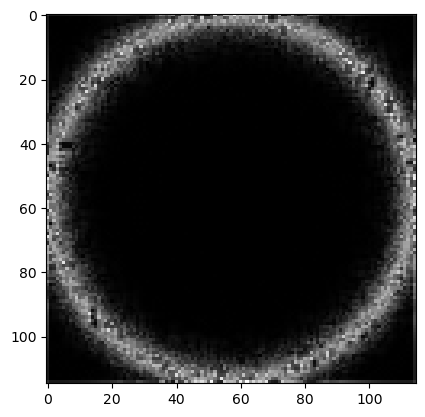

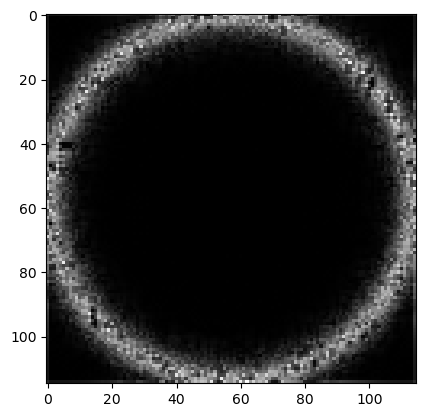

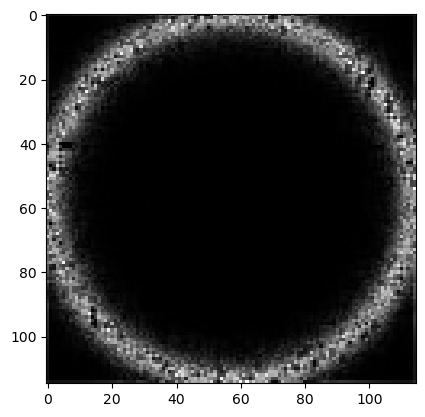

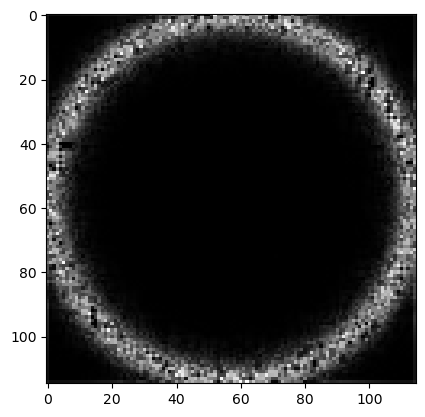

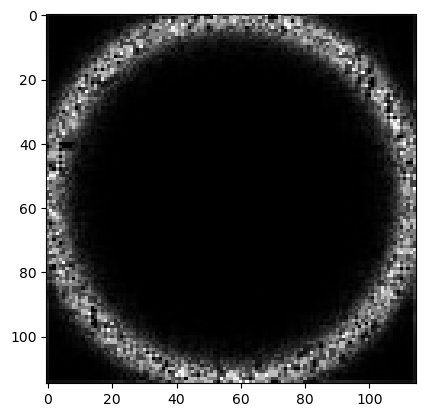

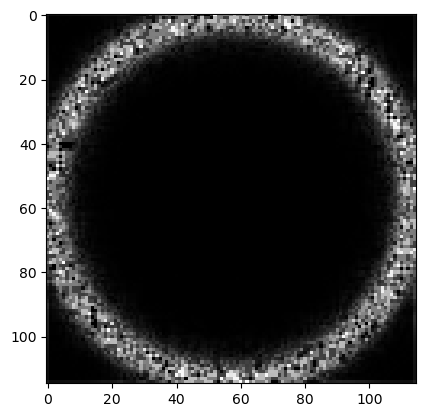

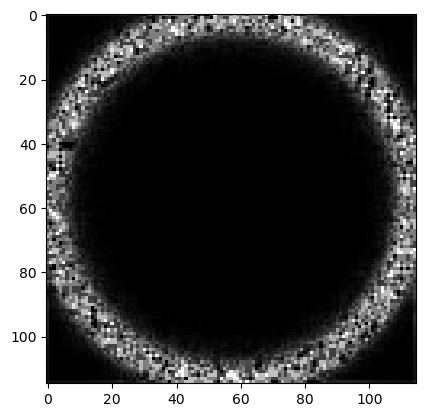

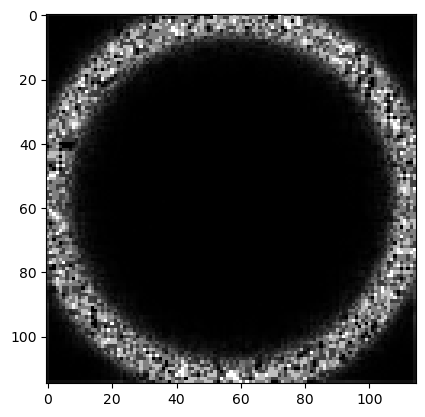

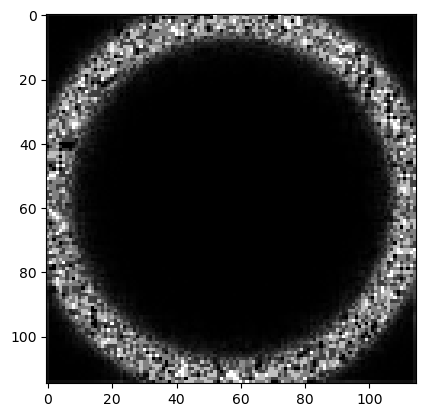

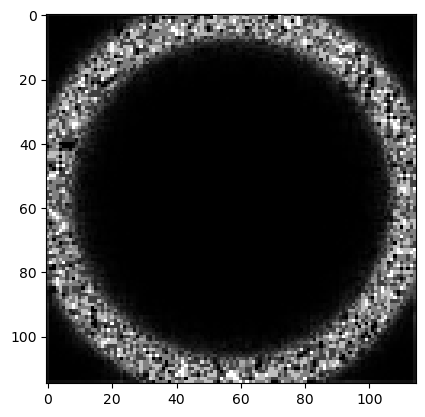

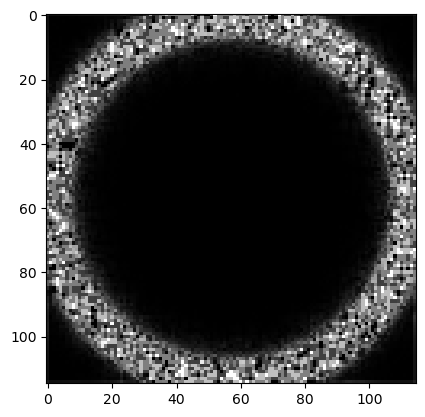

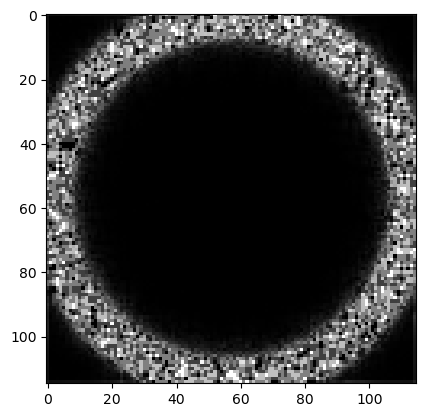

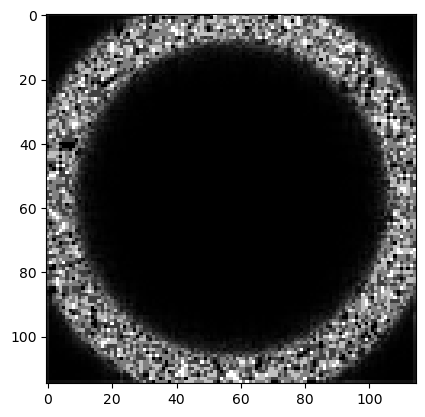

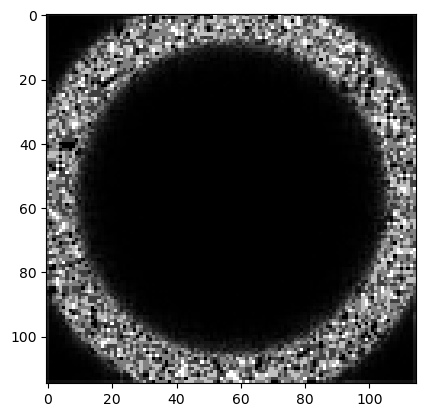

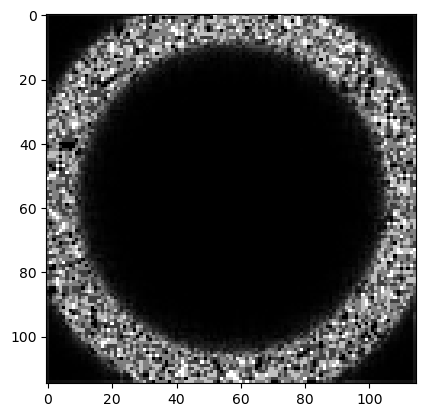

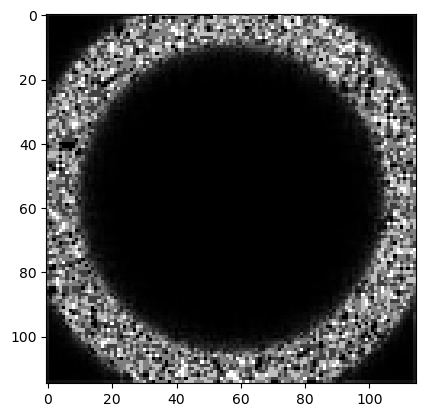

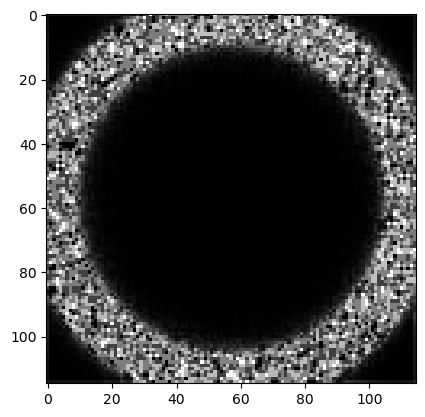

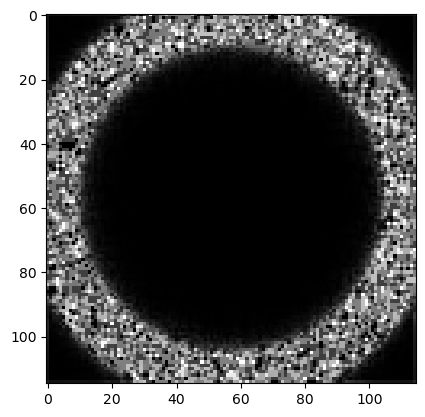

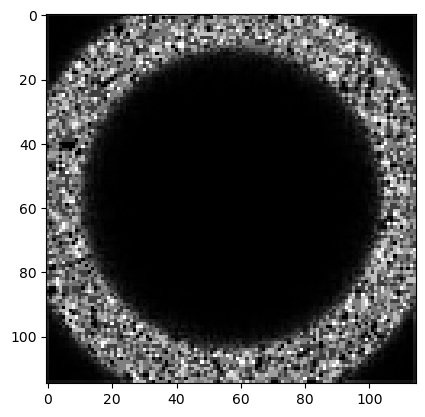

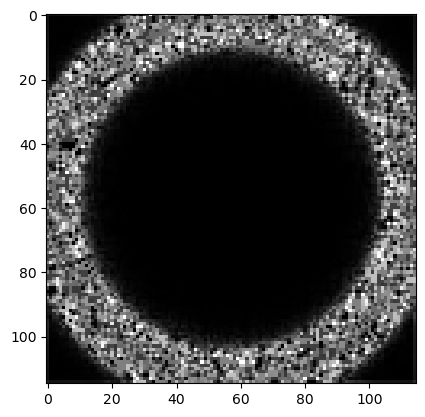

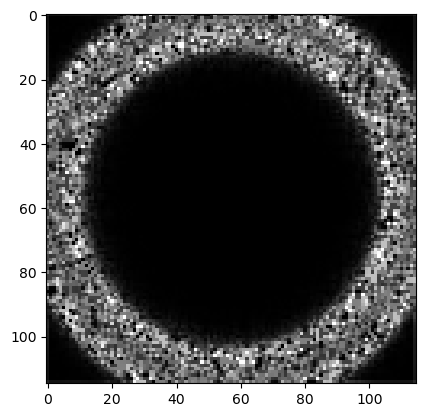

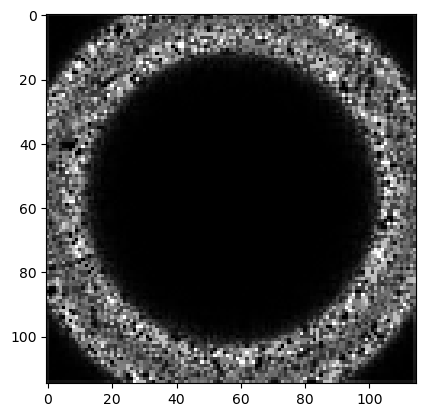

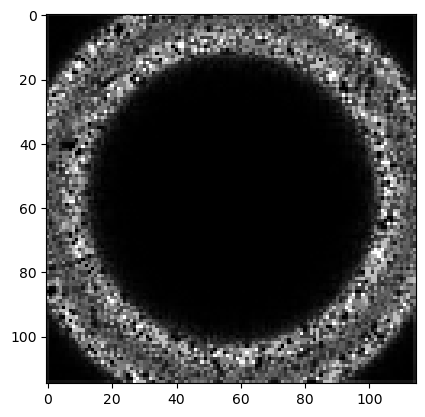

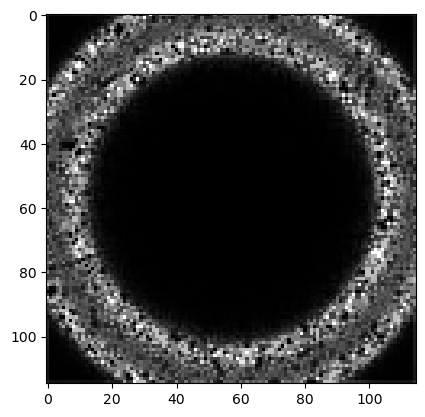

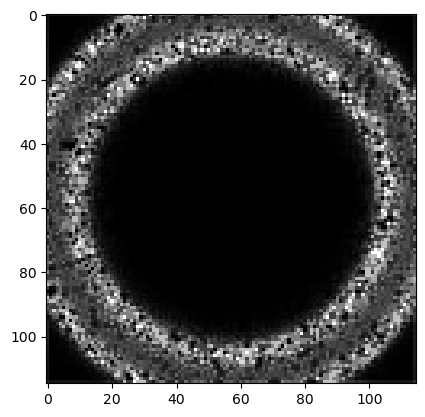

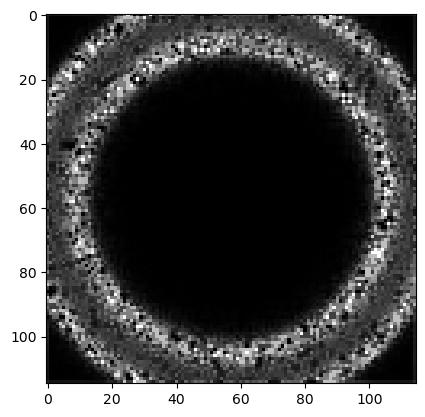

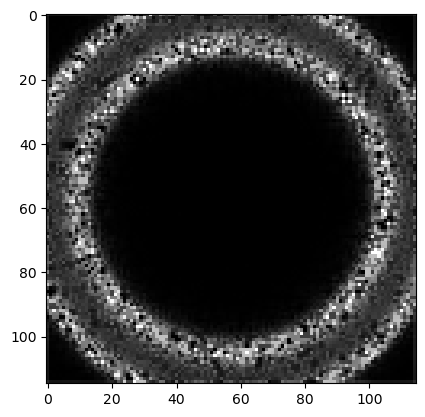

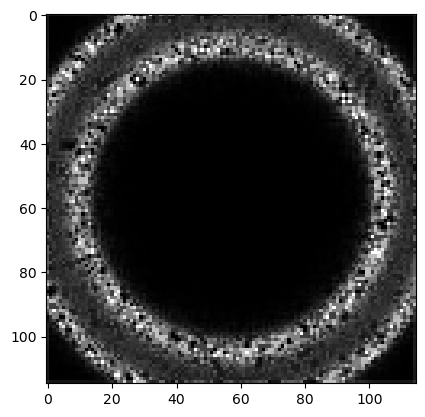

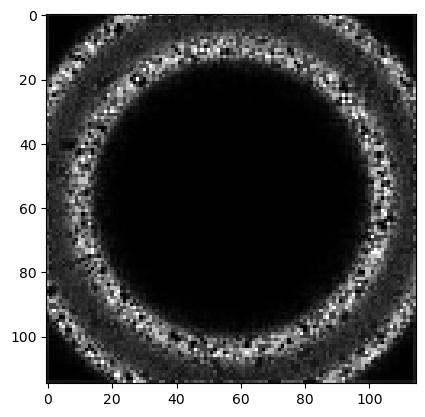

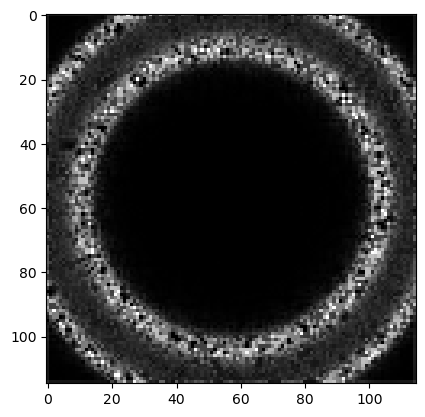

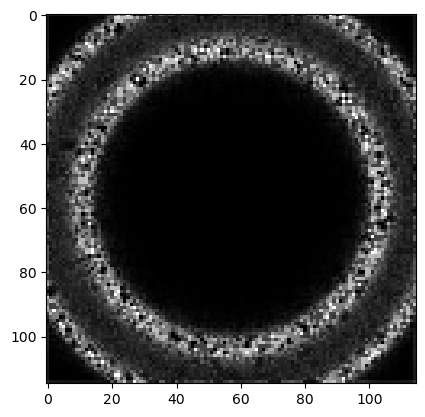

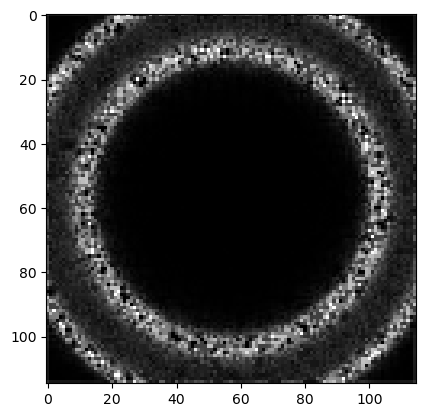

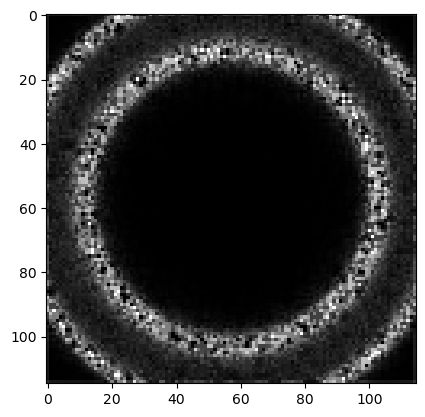

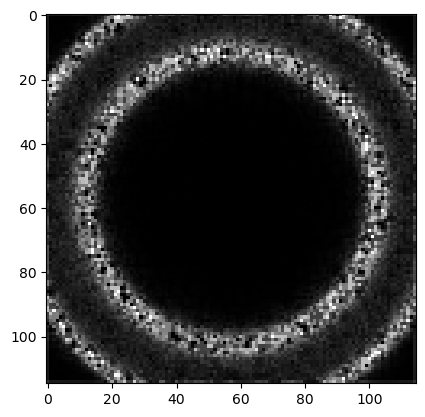

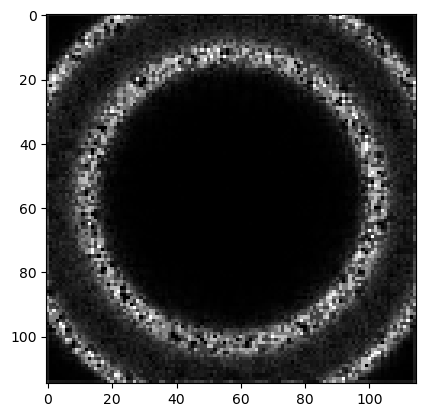

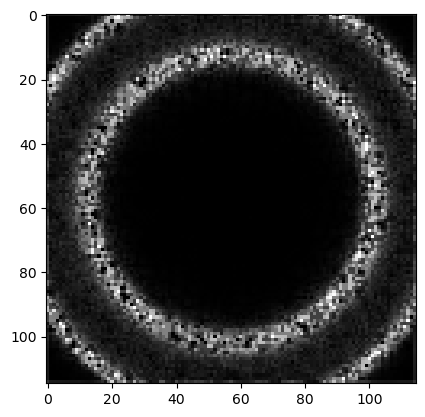

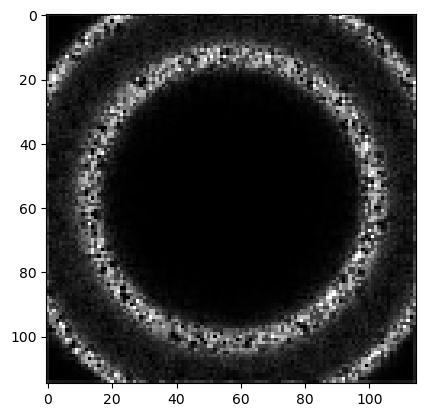

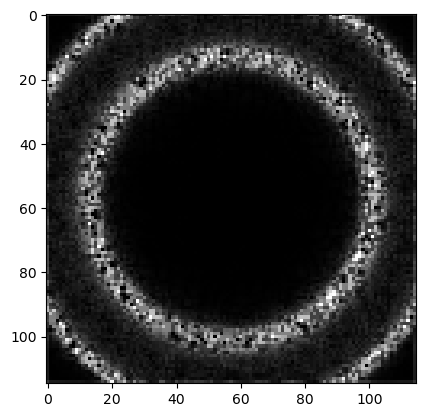

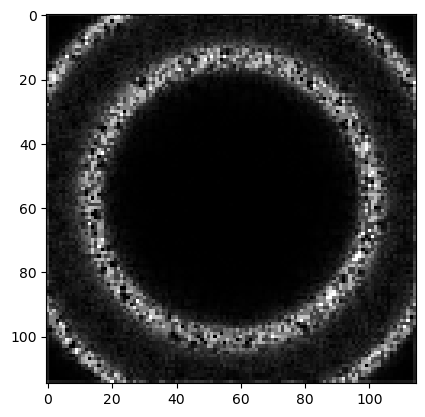

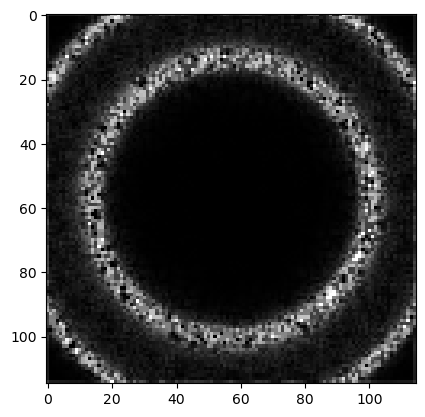

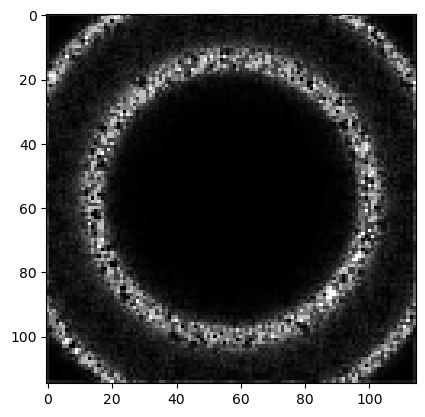

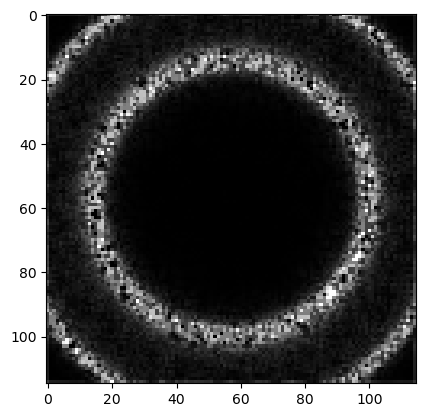

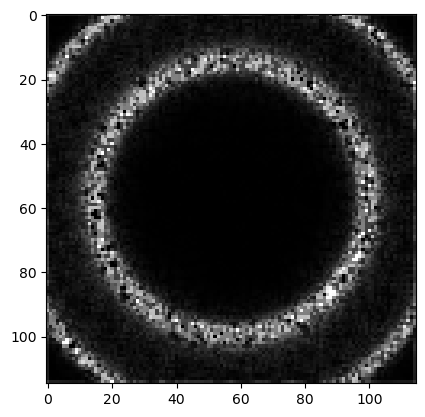

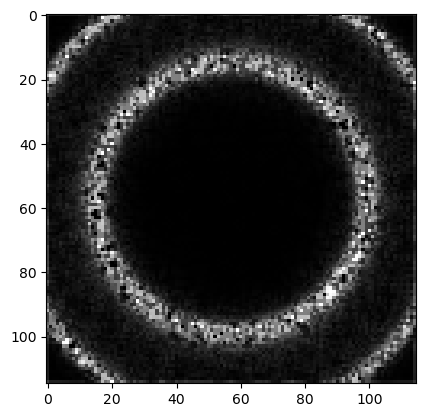

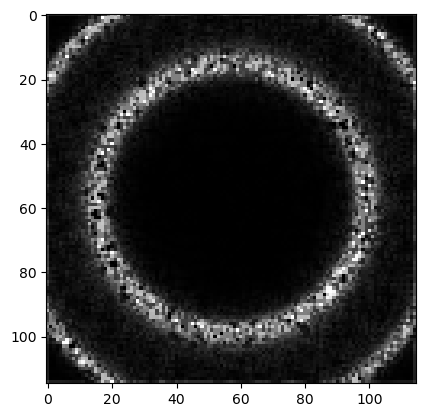

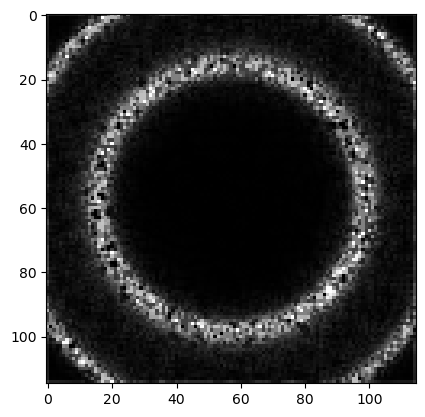

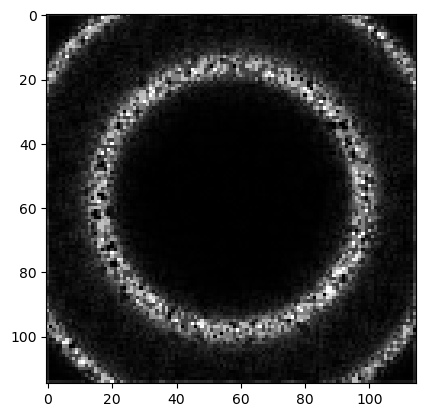

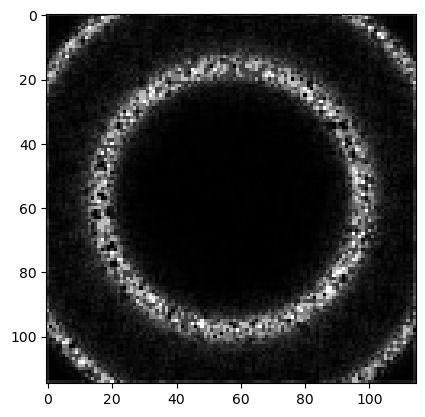

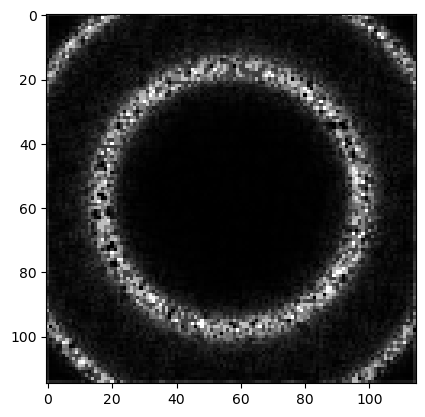

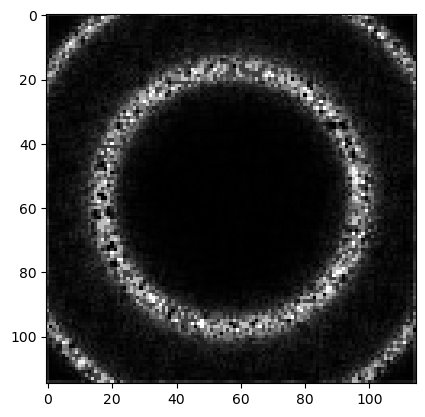

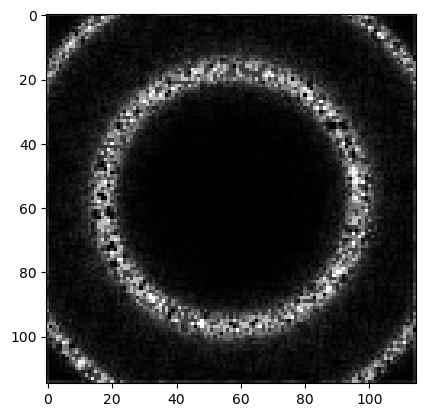

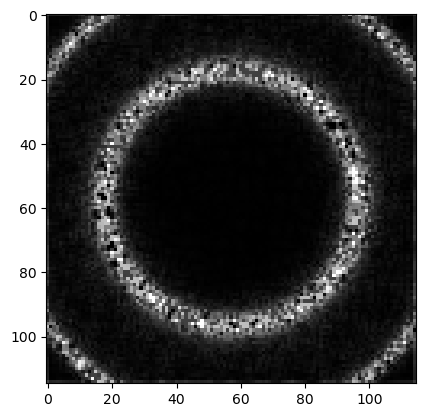

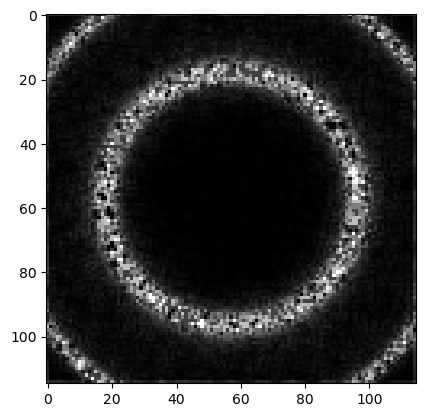

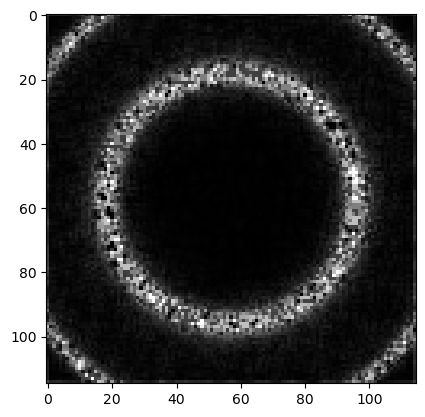

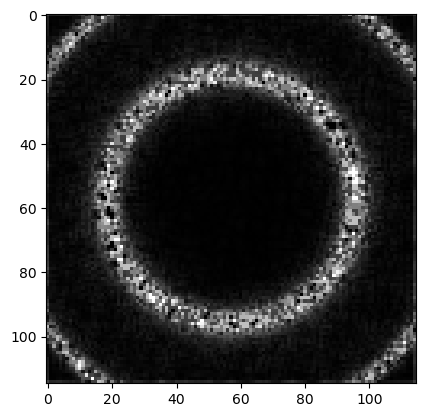

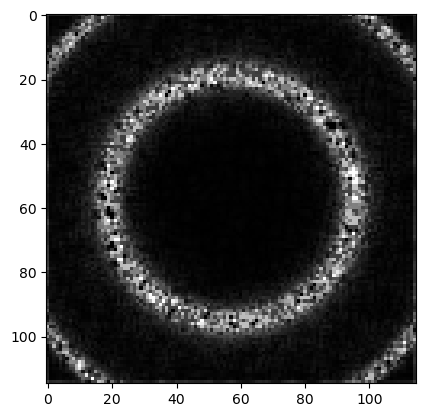

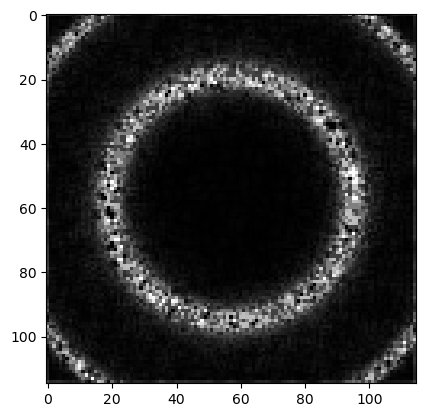

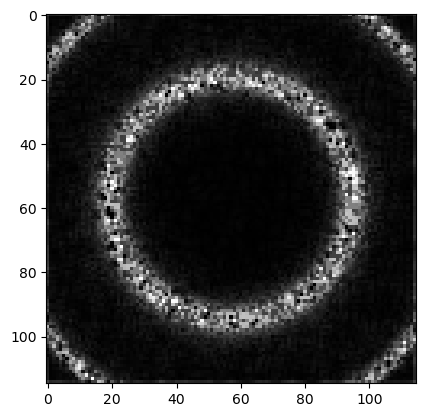

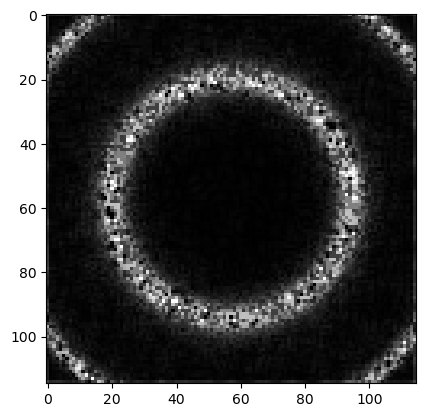

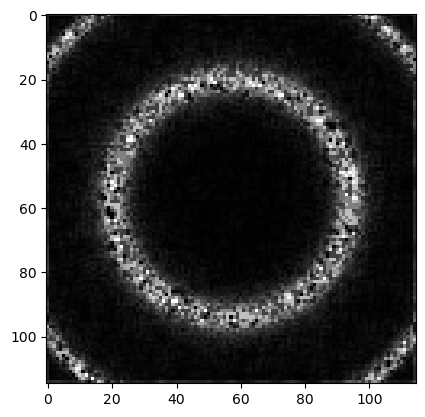

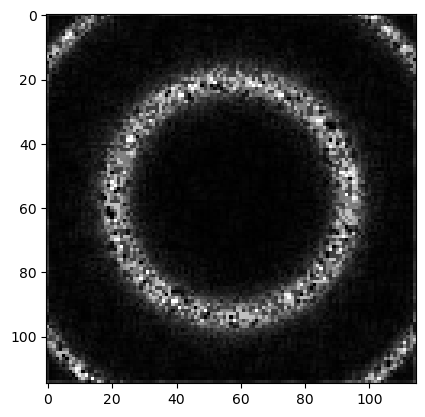

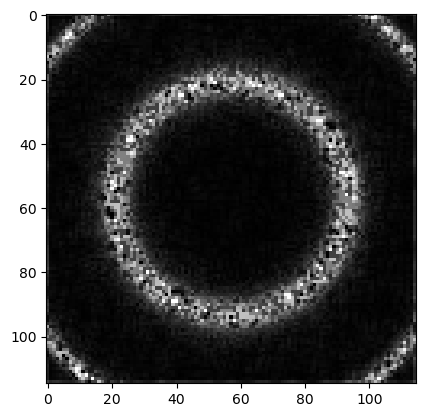

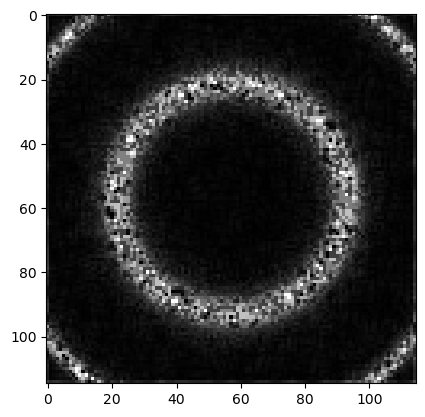

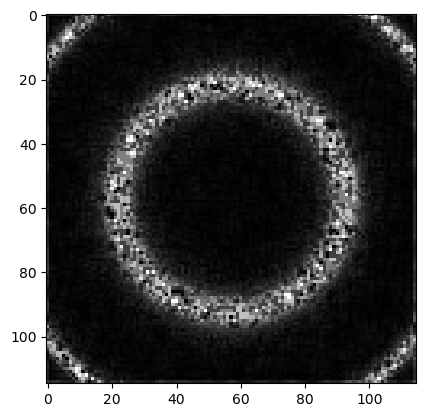

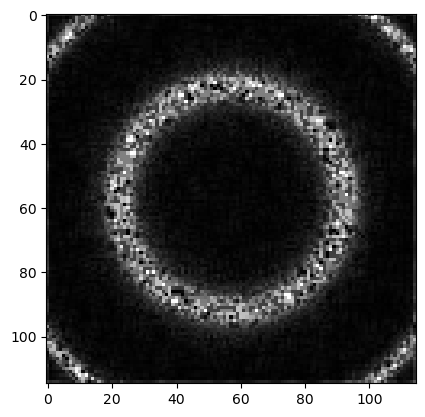

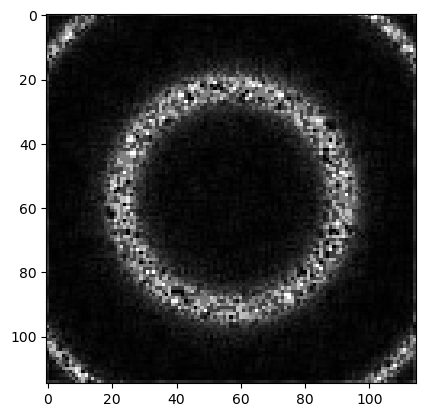

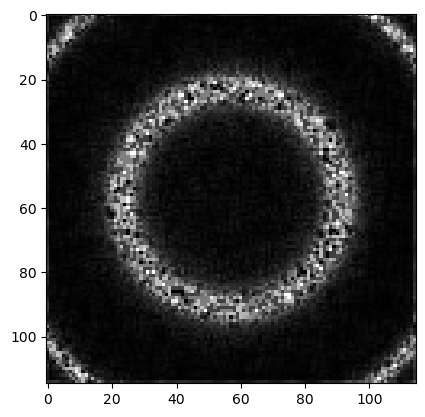

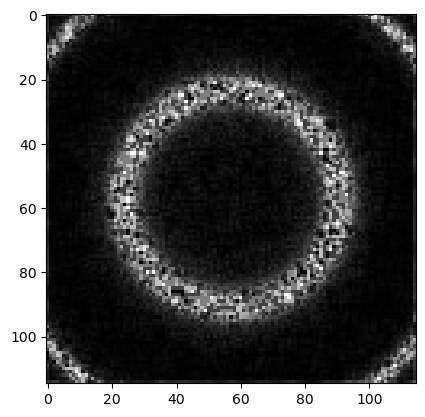

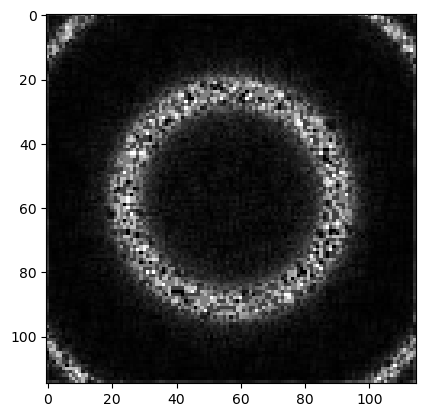

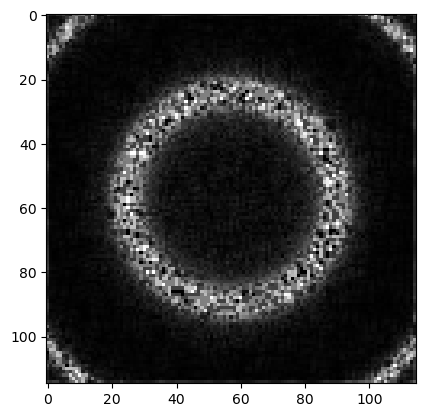

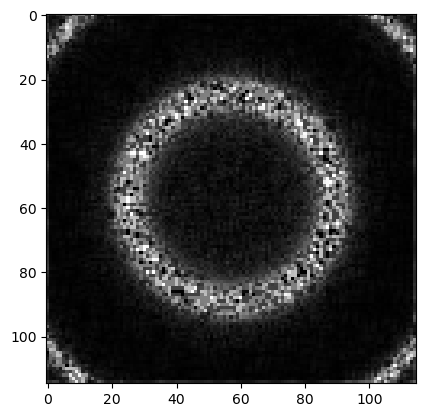

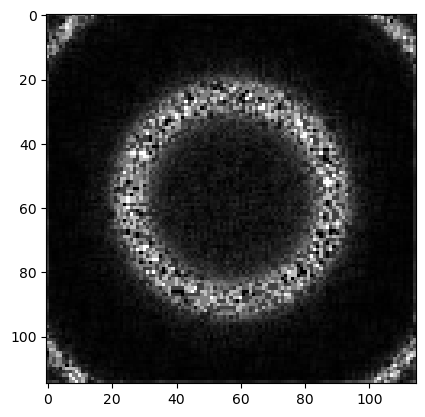

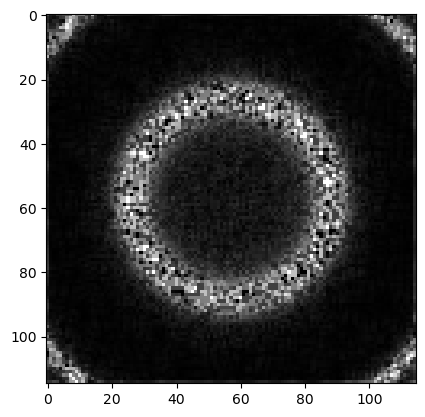

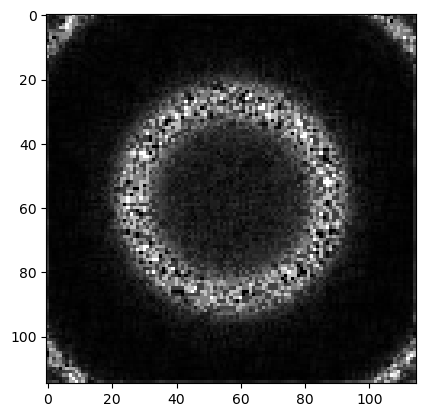

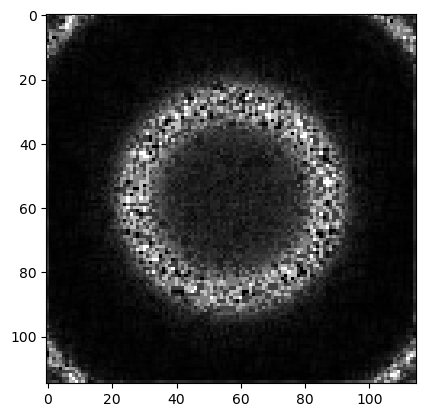

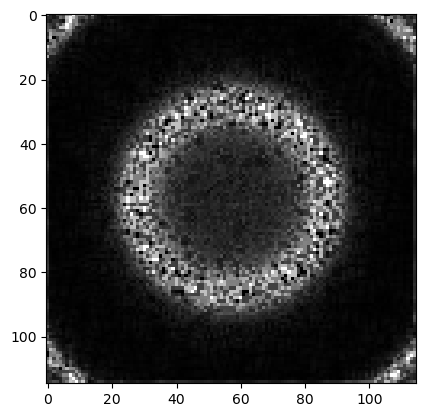

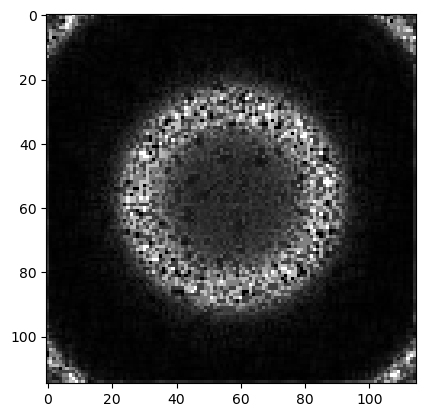

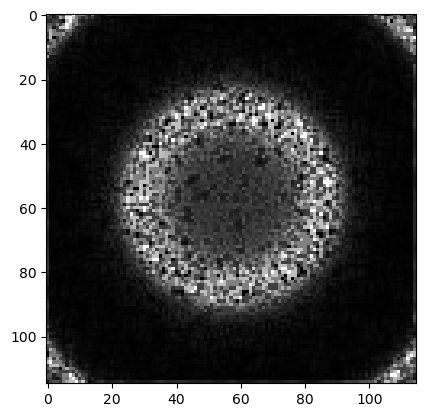

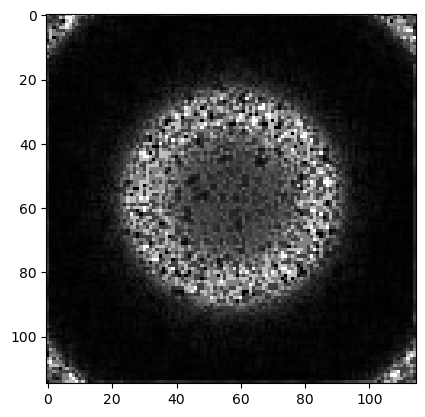

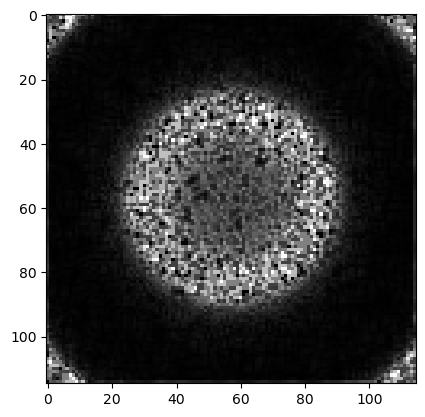

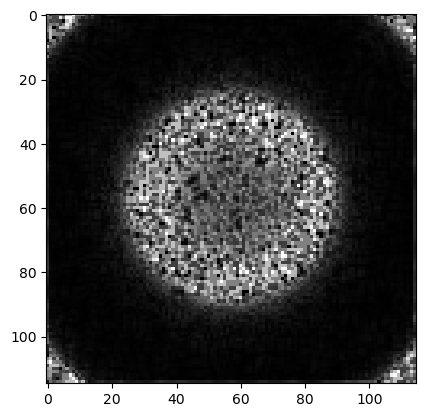

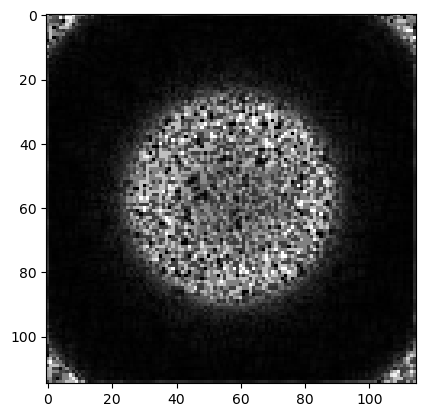

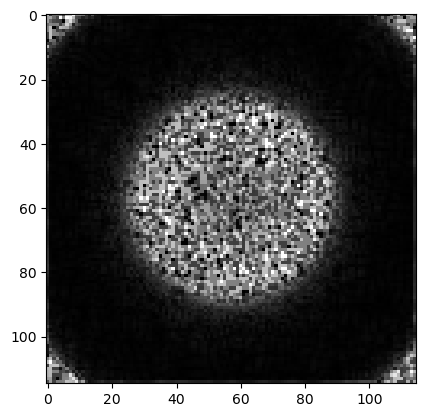

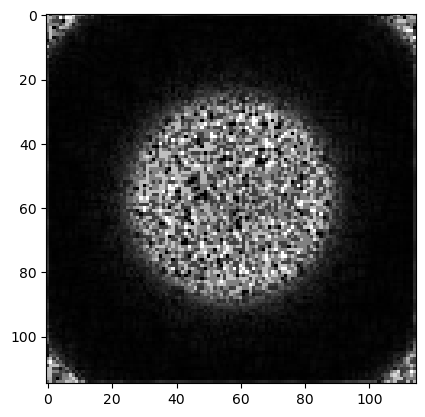

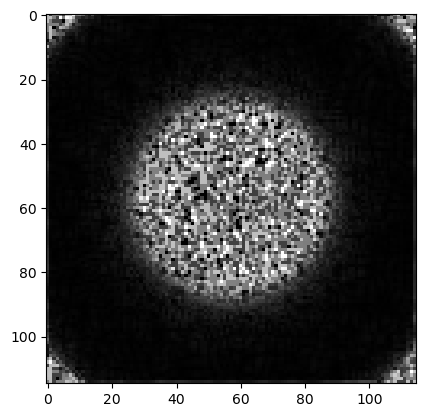

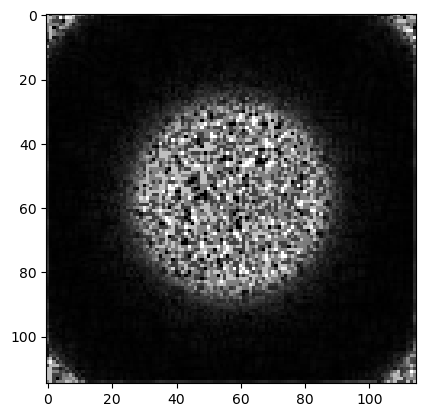

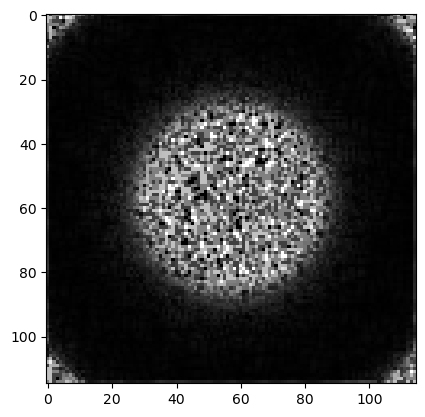

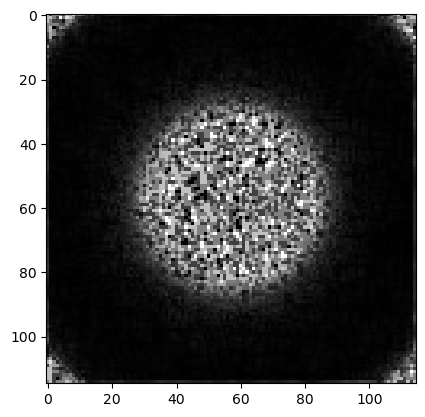

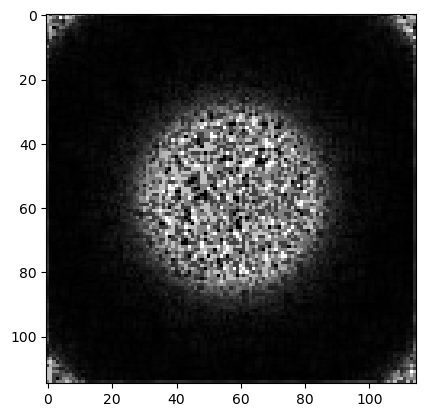

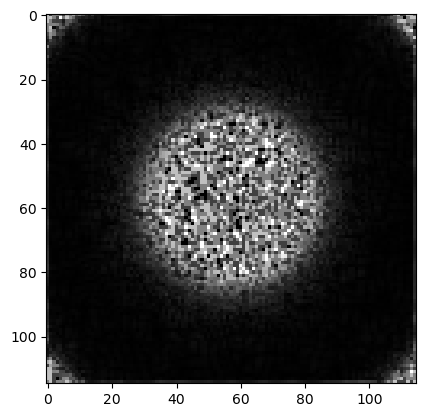

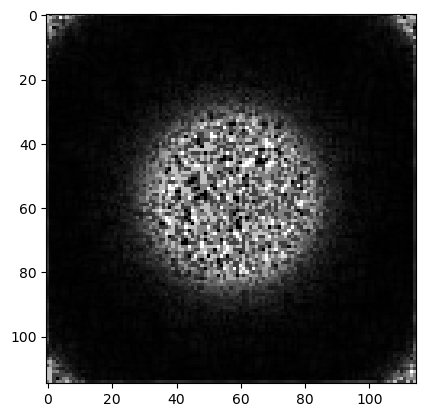

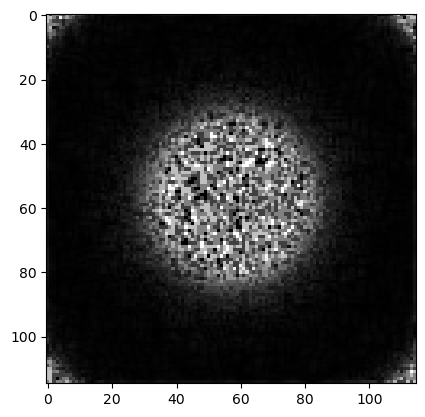

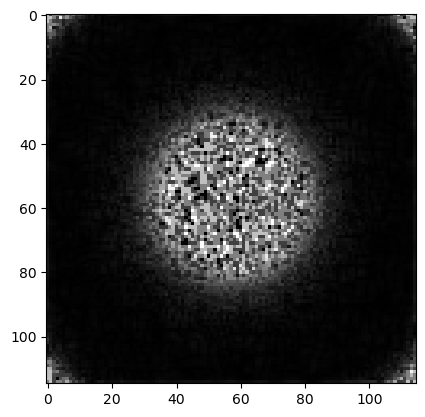

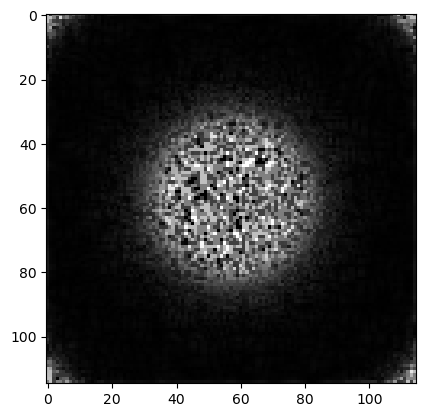

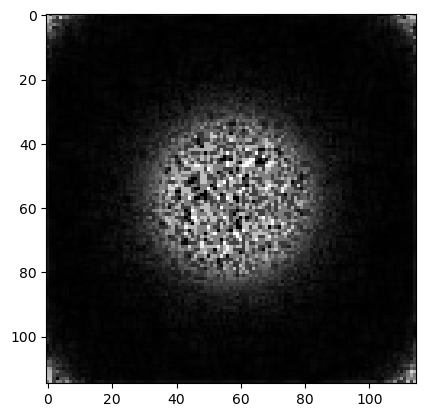

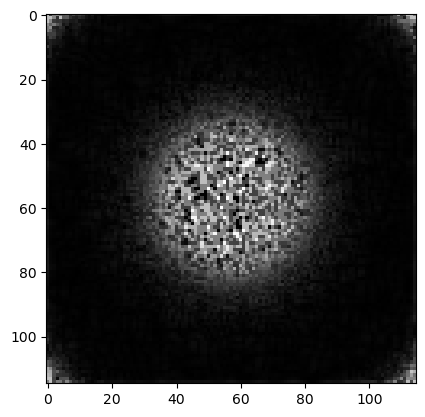

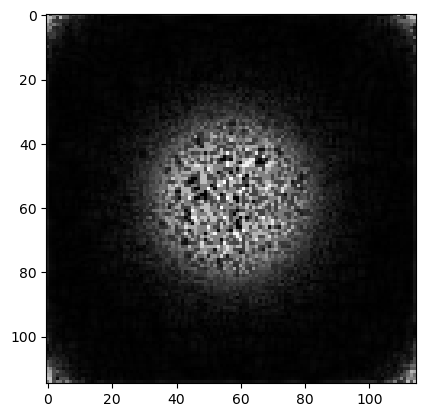

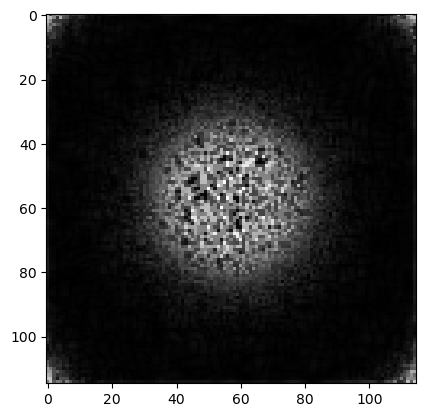

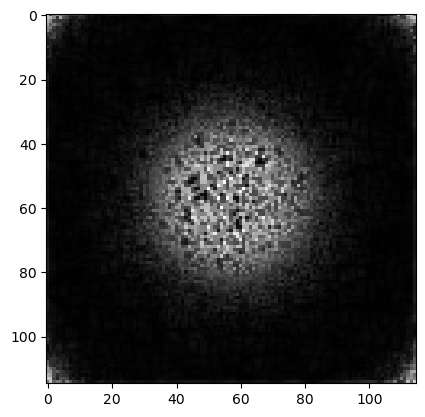

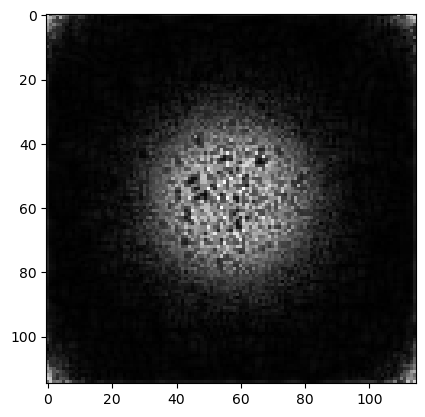

In [10]:
for i in tqdm(range(100)):
    plt.figure()
    if i<9:
        img_name = 'frame00{}'.format(int(i)+1)
        plt.imshow(ML[img_name],cmap='gray')
    elif i<99:
        img_name = 'frame0{}'.format(int(i)+1)
        plt.imshow(ML[img_name],cmap='gray')
    else:
        img_name = 'frame{}'.format(int(i)+1)
        plt.imshow(ML[img_name],cmap='gray')

### sum-modified Laplacian (SML)

In [11]:
def Sum_Modified_Laplacian(Stack_ML,q):
    new_stack = np.zeros([Stack_ML.shape[0],Stack_ML.shape[1],Stack_ML.shape[2]])
    for row in tqdm(range(Stack_ML.shape[1])):
        for col in range(Stack_ML.shape[2]):
            for i in range(q+1):
                if row-i>=0:
                    new_stack[:,row,col] += Stack_ML[:,row-i,col]
                if i!=0 and row+i<Stack_ML.shape[1]:
                    new_stack[:,row,col] += Stack_ML[:,row+i,col]
                if i!=0 and col-i>=0:
                    new_stack[:,row,col] += Stack_ML[:,row,col-i]
                if i!=0 and col+i<Stack_ML.shape[2]:
                    new_stack[:,row,col] += Stack_ML[:,row,col+i]
    return new_stack
            

In [12]:
def Gaussian_Interpolation(Focus_Measure,dist,dd):
    Fm = Focus_Measure[0]
    Fmp = Focus_Measure[1]
    Fmn = Focus_Measure[2]
    dm = dist[0]*dd
    dmp = dist[1]*dd
    dmn = dist[2]*dd
    d=dm
    if (2*dd*(2*np.log(Fm)-np.log(Fmn)-np.log(Fmp)))!=0:
        d = ((np.log(Fm)-np.log(Fmp))*(dmn**2-dm**2)-(np.log(Fm)-np.log(Fmn))*(dmp**2-dm**2))/(2*dd*(2*np.log(Fm)-np.log(Fmn)-np.log(Fmp)))
        #print(d)
    return d

In [13]:
def find_depth(new_Stack,dd):
    Z = np.zeros([new_Stack.shape[1],new_Stack.shape[2]])
    for row in tqdm(range(new_Stack.shape[1])):
        for col in range(new_Stack.shape[2]):
            Fm = []
            Dist = []
            dmi = np.argmax(new_Stack[:,row,col])
            Dist.append(dmi)
            Fm.append(new_Stack[dmi,row,col])
            if dmi-1>=0 and dmi+1<new_Stack.shape[0]:
                Dist.append(dmi-1)
                Fm.append(new_Stack[dmi-1,row,col])
                Dist.append(dmi+1)
                Fm.append(new_Stack[dmi+1,row,col])
                Z[row][col] = Gaussian_Interpolation(Fm,Dist,dd)
            else:
                Z[row][col] = dmi*dd
    return Z
    

In [14]:
SML = {}
Stack = []
for key in data.keys():
    Stack.append(ML[key])

In [15]:
Stack_1 = np.array(Stack)
Stack_1.shape

(100, 115, 115)

## 3D structure for q = 0

In [16]:
new_Stack = Sum_Modified_Laplacian(Stack_1,q=0)
Z=find_depth(new_Stack,dd=50.50)

100%|██████████| 115/115 [00:00<00:00, 412.95it/s]


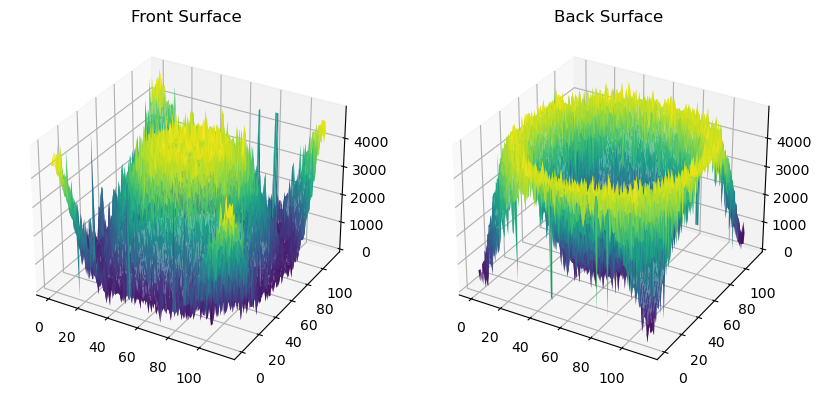

In [17]:
fig, ax = plt.subplots(1,2,subplot_kw={"projection": "3d"},figsize=[10,14])
X, Y = np.meshgrid(range(new_Stack.shape[1]), range(new_Stack.shape[2]))
ax[0].plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax[0].set_title('Front Surface');
ax[1].plot_surface(X, Y, Z.max()-Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax[1].set_title('Back Surface');

## 3D structure for q = 1

100%|██████████| 115/115 [00:00<00:00, 416.39it/s]


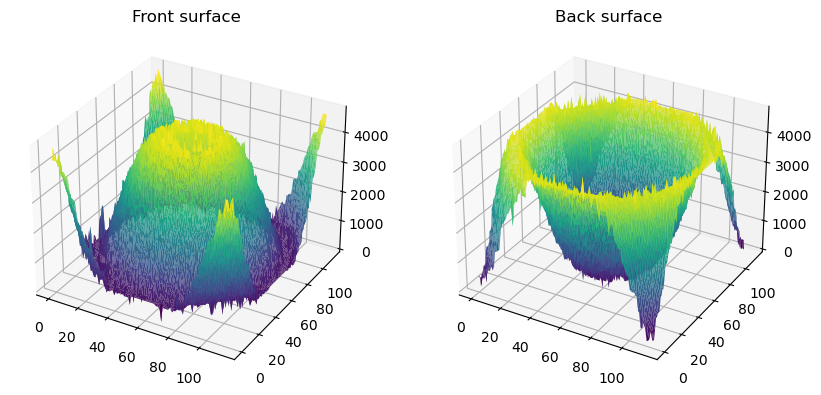

In [18]:
new_Stack = Sum_Modified_Laplacian(Stack_1,q=1)
Z = find_depth(new_Stack,dd=50.50)
fig, ax = plt.subplots(1,2,subplot_kw={"projection": "3d"},figsize=[10,14])
X, Y = np.meshgrid(range(new_Stack.shape[1]), range(new_Stack.shape[2]))
ax[0].plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax[0].set_title('Front surface');
ax[1].plot_surface(X, Y, Z.max()-Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax[1].set_title('Back surface');

## 3D structure for q = 2

100%|██████████| 115/115 [00:00<00:00, 408.24it/s]


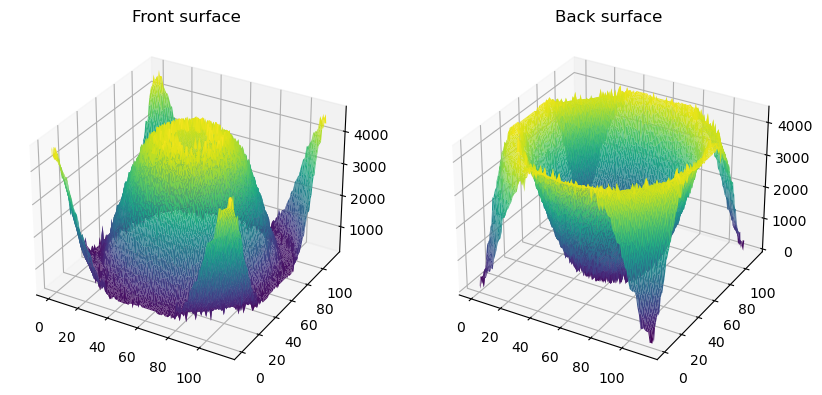

In [19]:
new_Stack = Sum_Modified_Laplacian(Stack_1,q=2)
Z = find_depth(new_Stack,dd=50.50)
fig, ax = plt.subplots(1,2,subplot_kw={"projection": "3d"},figsize=[10,14])
X, Y = np.meshgrid(range(new_Stack.shape[1]), range(new_Stack.shape[2]))
ax[0].plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax[0].set_title('Front surface');
ax[1].plot_surface(X, Y, Z.max()-Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax[1].set_title('Back surface');

## 3D structure for q = 3

100%|██████████| 115/115 [00:00<00:00, 409.71it/s]


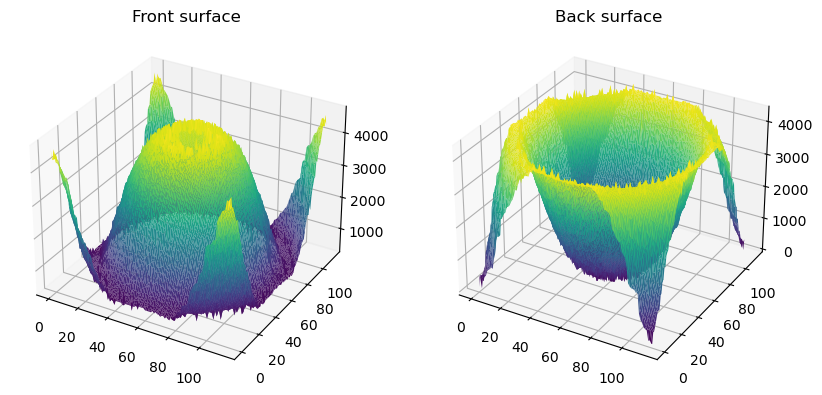

In [20]:
new_Stack = Sum_Modified_Laplacian(Stack_1,q=3)
Z = find_depth(new_Stack,dd=50.50)
fig, ax = plt.subplots(1,2,subplot_kw={"projection": "3d"},figsize=[10,14])
X, Y = np.meshgrid(range(new_Stack.shape[1]), range(new_Stack.shape[2]))
ax[0].plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax[0].set_title('Front surface');
ax[1].plot_surface(X, Y, Z.max()-Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax[1].set_title('Back surface');

100%|██████████| 115/115 [00:00<00:00, 404.84it/s]


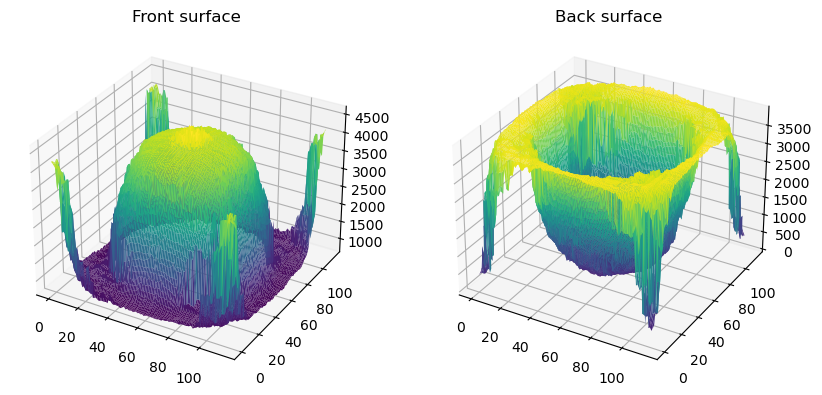

In [21]:
new_Stack = Sum_Modified_Laplacian(Stack_1,q=15)
Z = find_depth(new_Stack,dd=50.50)
fig, ax = plt.subplots(1,2,subplot_kw={"projection": "3d"},figsize=[10,14])
X, Y = np.meshgrid(range(new_Stack.shape[1]), range(new_Stack.shape[2]))
ax[0].plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax[0].set_title('Front surface');
ax[1].plot_surface(X, Y, Z.max()-Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax[1].set_title('Back surface');

There was noise in the surface formation with q=0 with increase in q the surface became smoother but as the q increases more and more the surface is getting deviating from actual surface.

In [22]:
for r in range(Stack_1.shape[1]):
    for c in range(Stack_1.shape[2]):
        if np.argmax(Stack_1[:,r,c])==np.argsort(Stack_1[:,r,c])[-2]:
            print(r,c)

0 2
0 5
0 7
0 21
0 23
0 31
0 32
0 47
0 49
0 68
0 76
0 79
0 84
0 93
0 105
0 109
1 18
1 32
1 71
1 87
1 88
1 100
1 108
2 12
2 38
2 77
2 78
2 79
2 86
2 92
2 93
2 105
2 106
2 109
2 112
3 13
3 16
3 17
3 21
3 25
3 27
3 36
3 49
3 78
3 85
3 92
3 105
3 111
4 9
4 13
4 27
4 59
4 61
4 62
4 89
4 94
4 105
4 111
5 2
5 14
5 20
5 33
5 50
5 64
5 91
5 101
5 106
6 11
6 23
6 31
6 38
6 41
6 44
6 63
6 64
6 73
6 86
6 87
6 94
6 100
7 2
7 15
7 25
7 51
7 60
7 74
7 75
7 85
7 86
7 95
7 108
8 16
8 24
8 29
8 30
8 42
8 47
8 72
8 98
8 102
9 17
9 22
9 30
9 31
9 32
9 45
9 46
9 49
9 66
9 68
9 82
9 86
9 87
10 20
10 25
10 34
10 55
10 86
10 93
10 96
10 100
10 108
11 12
11 23
11 31
11 39
11 42
11 45
11 55
11 57
11 59
11 60
11 61
11 65
11 77
11 81
11 82
11 91
11 92
11 93
11 100
11 105
12 9
12 13
12 22
12 23
12 24
12 50
12 53
12 59
12 62
12 71
12 88
12 92
12 105
13 11
13 18
13 20
13 22
13 23
13 33
13 34
13 35
13 49
13 51
13 55
13 66
13 69
13 71
13 79
13 81
13 85
13 108
14 3
14 4
14 15
14 21
14 22
14 37
14 51
14 53
14 61
14 66
1

In [23]:
Stack_1[:,114,108]

array([ 66.,  66.,  65.,  66.,  66.,  68.,  69.,  73.,  72.,  76.,  75.,
        78.,  78.,  81.,  82.,  82.,  82.,  87.,  87.,  89.,  86.,  87.,
        88.,  90.,  89.,  90.,  92.,  91.,  93.,  93.,  94.,  95.,  94.,
        95.,  97.,  96.,  98.,  97., 100.,  98., 101., 100., 100., 103.,
       102., 102., 103., 102., 102.,  98.,  99.,  99.,  99.,  99.,  98.,
        99., 103., 108., 112., 121., 129., 138., 152., 169., 186., 207.,
       230., 250., 276., 306., 330., 362., 391., 433., 490., 567., 655.,
       720., 756., 765., 765., 765., 765., 764., 762., 761., 762., 768.,
       772., 776., 776., 698., 645., 590., 534., 487., 440., 397., 358.,
       324.])

In [24]:
new_Stack = Sum_Modified_Laplacian(Stack_1,q=1)
new_Stack[:,114,108]

100%|██████████| 115/115 [00:00<00:00, 1105.39it/s]


array([ 198.,  198.,  198.,  202.,  202.,  206.,  211.,  218.,  219.,
        228.,  228.,  234.,  237.,  245.,  249.,  251.,  250.,  260.,
        263.,  264.,  263.,  267.,  270.,  271.,  275.,  276.,  279.,
        281.,  285.,  284.,  289.,  289.,  291.,  295.,  297.,  298.,
        302.,  301.,  306.,  305.,  308.,  307.,  305.,  312.,  311.,
        310.,  309.,  311.,  313.,  309.,  307.,  310.,  306.,  309.,
        314.,  320.,  329.,  335.,  346.,  361.,  374.,  385.,  401.,
        435.,  501.,  586.,  682.,  799.,  933., 1088., 1245., 1417.,
       1593., 1768., 1927., 2043., 2161., 2248., 2291., 2298., 2292.,
       2286., 2280., 2268., 2251., 2223., 2169., 2105., 2013., 1926.,
       1834., 1655., 1513., 1372., 1244., 1130., 1013.,  920.,  830.,
        750.])